Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
import math

%matplotlib inline

## K-Fold cross validation - Helper methods

In [16]:
def generate_folds(X, k, randomize = False):
    """
    Generates k (training, validation) pairs from
    the given data
    
    Parameters
    ----------
    X : Nxd matrix
        where N is the total number of input data
        points and d is the number of features
    k : Integer
        Number of folds to be generated
    randomize : boolean
        True iff data must be shuffled before
        being split into (training, validation)
        pairs
    
    Yields
    ------
    k (training, validation) pairs
    """
    
    # Shuffle the data if necessary    
    if randomize:
        X = list(X)
        r.shuffle(X)
    
    for i in range(k):
        training = [x for j, x in enumerate(X, start = 1) if j % k != i]
        validation = [x for j, x in enumerate(X, start = 1) if j % k == i]
        yield training, validation

def do_k_fold_CV(data, result_col_name, theta, alpha, l2_penality_values, K):
    
    # For each value of L2 penality, compute
    # the average MSE after fitting a model
    # for each fold
    l2_penality_mse = np.zeros(len(l2_penality_values))
    
    # Define variables to track the min MSE
    # and best L2 penality
    min_mse = None
    best_l2_penality = None
    
    # Create as many folds as needed for cross
    # validation and run logistic regression on
    # each training-validation pair
    for training, validation in generate_folds(data.values, K, True):
        # Convert the splits into dataframe
        data_cols = list(data.columns.values)
        t_df = pd.DataFrame(training, columns=data_cols)
        v_df = pd.DataFrame(validation, columns=data_cols)
        
        # Split the datasets into X and Y
        data_cols.remove(result_col_name)
        t_X = t_df[data_cols]
        t_Y = t_df[[result_col_name]]
        v_X = v_df[data_cols]
        v_Y = v_df[[result_col_name]]
        
        # Convert X and Y into matrices
        t_X = np.matrix(t_X.values)
        t_Y = np.matrix(t_Y.values)
        v_X = np.matrix(v_X.values)
        v_Y = np.matrix(v_Y.values)
        
        for i, l2_penality in enumerate(l2_penality_values):
            # Initialize theta
            t_theta, error, cost = gradient_descent(t_X, t_Y, theta, alpha, l2_penality)
            # Predict validation set outputs
            v_Y_prediction = v_X * t_theta
            #print("v_Y_prediction: ", v_Y_prediction.shape)
            v_l1_error = v_Y_prediction - v_Y
            #print("v_l1_error: ", v_l1_error.shape)
            v_l2_error = v_l1_error.T * v_l1_error
            #print("v_l2_error: ", v_l2_error.shape)
            l2_penality_mse[i] += v_l2_error.sum()
    
    l2_penality_mse = l2_penality_mse / K
    
    # Find the min mse and corresponding l2 penality
    min_mse = None
    best_l2_penality = None
    
    for i, val in enumerate(l2_penality_mse):
        if min_mse is None or val < min_mse:
            min_mse = val
            best_l2_penality = l2_penality_values[i]            
    
    return l2_penality_mse, best_l2_penality

def generate_model(path, x_col, result_col_name, theta, alpha, folds = None):
    train_data = load_data(path, x_col, result_col_name)
    X, Y = pre_process(train_data, result_col_name)
    
    if folds is None:
        folds = X.shape[0]
    
    # K-fold CV
    l2_penality_values = np.logspace(-2, -1, num=10)
    l2_penality_mse, best_l2_penality = do_k_fold_CV(train_data, result_col_name, theta, alpha, l2_penality_values, folds)
    print("L2 Penality MSEs: ", l2_penality_mse)
    print("Best L2 penality value: ", best_l2_penality)
    
    plot_cv_error(l2_penality_values, l2_penality_mse)
    
    theta, error, cost = gradient_descent(X, Y, theta, alpha, best_l2_penality)
    print("Theta: ", theta)
    print("Regression error: ", sum(error))
    print("Train error: ", sum(cost))
    
    plot_data(train_data, result_col_name, theta)
    
    return theta

def predict(path, x_col, result_col_name, theta):
    test_data = load_data(path, x_col, result_col_name)
    X, Y = pre_process(test_data, result_col_name)
    
    #error = computeError(X, Y, theta)
    #print("Regression error: ", error.sum())
    
    #cost = computeCost(error)
    #print("Test error: ", cost.sum())
    
    plot_data(test_data, result_col_name, theta)

def plot_cv_error(l2_penality_values, l2_penality_mse):
    plt.plot(l2_penality_values, l2_penality_mse, 'k-')
    plt.xlabel('$\ell_2$ penalty')
    plt.ylabel('K-fold cross validation error')
    plt.xscale('log')
    plt.yscale('log')

## Helper Functions

In [12]:
def load_data(path, x_col, y_col):
    """
    Reads the contents of a matlab file into
    a dataframe
    
    Parameters
    ----------
    path : String
        Relative path to the input data file
    x_col : String
        Header of the column storing features
    y_col : String
        Header of the column storing actual
        classes
    
    Returns
    -------
    Pandas DataFrame
        Contains the data read from the file
    """
    # Load the data
    data = sio.loadmat(path)
    
    # Convert to dataframe
    data = pd.DataFrame(
                np.hstack(
                    (data[x_col],
                     data[y_col])))
    
    # Define the column headers
    data.columns = ['x1', 'x2', y_col]
    
    # Return the data
    return data

def pre_process(data, y_col):
    """
    Split the input data into a matrix that
    contains all features and a matrix that
    contains all output classes
    
    Parameters
    ----------
    data : Pandas DataFrame
        Contains the input data
    y_col : String
        Header of the result column
    
    Returns
    -------
    N x (d + 1) matrix
        Storing d features for N samples
    N x 1 matrix
        Storing the classification for N
        samples
    """
    data.insert(0, "ones", 1)
    data_cols = list(data.columns.values)
    data_cols.remove(y_col)
    
    X = data[data_cols]
    X = np.matrix(X.values)
    
    Y = data[[y_col]]
    Y = np.matrix(Y.values)
    
    return X, Y

def compute_prediction(W, H):
    """
    Computes the prediction using sigmoid
    function: 1 / (1 + e ^ (-z)) where z
    is the score given by z = w.T * h(x).
    
    Parameters
    ----------
    W : (d + 1) x 1 matrix
        where d is the number of features.
        It must contain the regression 
        coefficients from previous iteration.
    H : N x (d + 1) matrix
        where N is the number of data points
        and d is the number of features. It
        must contain the input dataset.
    
    Returns
    -------
    N x 1 matrix
        which contains the predicted class
        for each input data point
    """
    Z = H * W  # Results in a N x 1 matrix    
    return 1 / (1 + (np.exp(-Z)))  # Predict

def compute_coefficients(W, H, Y, alpha, l2_penality):
    """
    Computes the regression coefficients
    for the next iteration of the program
    using the formula: W - H.T * (Y - P)
    where P is the predicted classification
    for each data input.
    
    Parameters
    ----------
    W : (d + 1) x 1 matrix
        Contains the regression coefficients
        from the previous iteration
    H : N x (d + 1) matrix
        Contains input data in the form of
        a matrix
    Y : N x 1 matrix
        Contains the true classes of all
        inputs
    alpha : Double
        The learning rate for this algorithm
    l2_penality : Double
        The L2 penality to be applied
    
    Returns
    -------
    (d + 1) x 1 matrix
        which contains the new values for
        regression coefficients
    """
    P = compute_prediction(W, H)  # Predict
    return W + alpha * (H.T * (Y - P) - l2_penality * W)  # Calculate coefficients

def compute_cost(H, Y, W, l2_penality):
    """
    Computes the overall cost incurred while
    predicting the classification for all
    input data points.
    
    Parameters
    ----------
    H : N x (d + 1) matrix
        Contains the input data in the form
        of a matrix
    Y : N x 1 matrix
        Contains the true classes of all input
        data points
    W : (d + 1) x 1 matrix
        Contains the regression coefficients
    l2_penality : Double
        The L2 penality to be applied
    
    Returns
    -------
    Double
        The overall cost
    """
    # Calcualte -(h(x) * w)
    prod = H * W
    prod = -(prod)
    
    # Calculate regularization term
    reg = np.sum(W * W.T)
    reg = (l2_penality / 2) * pow(reg, 0.5)
    
    # Calculate (1 - 1(y = +1)) * -(h(x) * w)
    first_term = np.multiply((1 - Y), prod)
    
    # Calculate ln(1 + e ^ -(h(x) * w))
    second_term = np.log(1 + np.exp(prod))
    
    # Calculate log likelihood
    cost = first_term - second_term
    
    # Calculate the overall cost
    return np.sum(cost, axis=0) + reg

def gradient_descent(H, Y, W, alpha, l2_penality):
    """
    Performs gradient descent on the given
    data and returns the final regression
    coefficients in the form of a column 
    vector
    
    Parameters
    ----------
    H : N x (d + 1) matrix
        Contains input data in the form of
        a matrix
    Y : N x 1 matrix
        Contains the true classes for each
        input
    W : (d + 1) x 1 matrix
        Contains the initial values of
        regression coefficients
    alpha : Float
        Contains the learning rate of this
        algorithm
    l2_penality : Double
        The L2 penality to be applied
    
    Returns
    -------
    (d + 1) x 1 matrix
        which contains the regression
        coefficients at the end of execution
    Array<Double>
        Cost incurred in each iteration
    """
    temp = np.matrix(np.zeros(W.shape))
    error = []
    cost = []
    i = 0
    
    while True:
        # Predict using W from previous iteration
        P = compute_prediction(W, H)
        P = vector_indicator(P)
        
        # Calculate the number of miscalculations and
        # the cost incurred
        error.append(np.sum(np.absolute(Y - P), axis=0).getA()[0][0])
        cost.append(compute_cost(H, Y, W, l2_penality).getA()[0][0])
        
        W = compute_coefficients(W, H, Y, alpha, l2_penality)        
        
        # Break out of the loop only when the cost
        # incurred is less than the threshold
        if ((i > 0) and 
            (cost[i] - cost[i - 1] < 0.001)):
            #print("Iterations: ", i)            
            #print("Miscalculations: ", error[i])
            #print("Cost: ", cost[i])
            break
        
        i += 1
    
    return W, error, cost

def plot_data(data, y_col, W):
    x = np.linspace(data.x1.min(), data.x1.max(), 100)
    
    f = 0
    for i in range(len(W)):
        f += x * W.getA()[i][0]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Draw the plots
    ax.plot(x, f, 'r', label='Classifier')
    ax.scatter(data.x1, data.x2, label='Data', c=data[[y_col]])
    
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')
    
    # Set the x and y axis limits for the plot
    x1_min = data.x1.min()
    x1_max = data.x1.max()
    ax.set_xlim(x1_min + 0.2 * x1_min, x1_max + 0.2 * x1_max)
    
    x2_min = data.x2.min()
    x2_max = data.x2.max()
    ax.set_ylim(x2_min + 0.2 * x2_min, x2_max + 0.2 * x2_max)

def indicator(score):
    """
    Indicator function which returns 1
    if the score is > 0.5. Else, returns
    0. This method assumes that score has
    already been scaled down to [0, 1] 
    using the sigmoid function.
    
    Parameters
    ----------
    score : Double
        A value between 0 and 1 (both 
        inclusive)
    
    Returns
    -------
    Integer (either 0 or 1)
    """
    return 1 if (score >= 0.5) else 0

vector_indicator = np.vectorize(indicator)

L2 Penality MSEs:  [ 992.03832267  980.55379     966.0148987   948.14582606  925.79803147
  898.29152724  865.54868313  826.74976843  782.27846315  732.43956361]
Best L2 penality value:  0.1
Theta:  [[ 2.18566579]
 [ 5.04741547]
 [-1.31540607]]
Regression error:  1119.0
Train error:  -4146.60732656


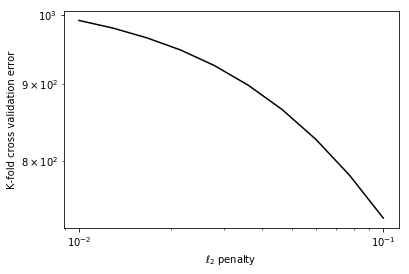

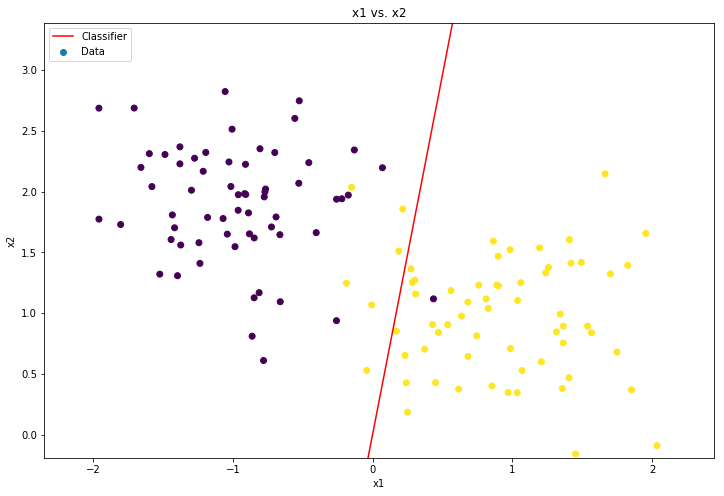

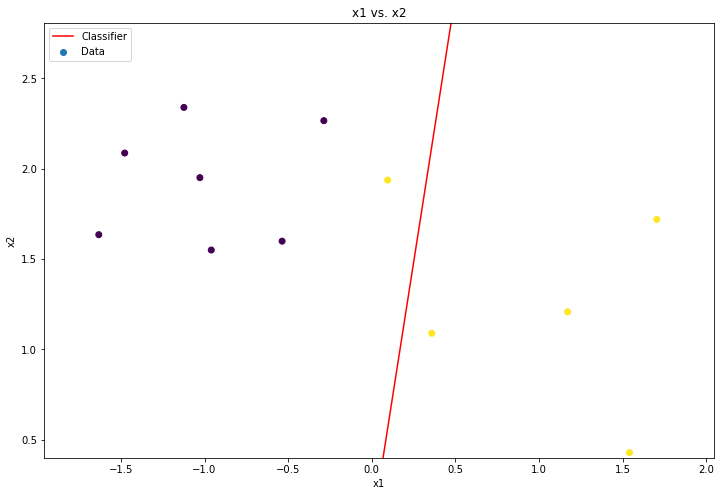

In [22]:

# ----------------------- Execution -----------------------------------

path = "data2.mat"  # Input data path
x_col = 'X_trn'
result_col_name = "Y_trn"

alpha = 0.01

folds = 5
theta = np.matrix(np.zeros(3))

reg_params = generate_model(path, x_col, result_col_name, theta.T, alpha, folds)

x_col = "X_tst"
result_col_name = "Y_tst"
predict(path, x_col, result_col_name, reg_params)